# Forecast Champagne Sales

This is a project for insights into a winery's champagne sales during the period 1964 to 1972. This data is a time serie available from [Kagle](https://www.kaggle.com/anupamshah/perrin-freres-monthly-champagne-sales).

## 1. Business questions

- 1. Is there a significant trend in the increase in sales of champagne?

- 2. Is there a significant seasonal effect on champagne sales?

- 3. Is it possible to build a model to predict next year's sales?

Because the dataset is composed of a time series with only two columns, time and sales price, it is not possible to answer many questions and answer many assumptions about this company's champagne sales.

## 2. Questions about some business assumptions

- A. In which month is the most champagne sold?

- B. Which month represents the lowest sale?

- C. Is it possible to quantify a growth rate in sales?

## Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

#personal library
import timeserietools as tst

import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
%matplotlib inline

## Champagne Dataset

Analysis of the available dataset and beginning of answers to some of the questions and business assumptions.

In [2]:
# Read the dataset as a timeserie format
serie = pd.read_csv("../Projects/datasets/champagne_sales.csv", header=0, index_col=0, parse_dates=True, squeeze=True)

# Read the dataset as a dataframe format
serie_df = pd.read_csv("../Projects/datasets/champagne_sales.csv")

In [3]:
# View first elements in data frame
serie_df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [4]:
# View the columns data type
serie_df.dtypes

Month    object
Sales     int64
dtype: object

In [5]:
# Describe statistic
serie.describe()

count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Sales, dtype: float64

### Answare business questions 

#### Trend and Seasonal analysis

First we index the month column to our dataset index, as well as transform the month column to datetime format.

With the ts_trendseason function, from the self-created timeseriestools library, we can analyze the trend and seasonality of our series graphically with an overview and by month. As well as we can perform a descriptive analysis per month of the series studied. the functions *ts_trendseason* and *ts_feature* are in the working library *timeserietools*, maintained by the author and available on [Github](https://github.com/WesleyJw/Learning/blob/main/TimeSeries/timeserietools.py).

In [6]:
#Transform month colum to datetime
serie_df['Month'] =  pd.to_datetime(serie_df['Month'], format='%Y-%m') 

#Get the number of each month
serie_df["month_n"] = serie_df.Month.dt.month

#index row by month column
serie_df.set_index("Month",inplace=True)

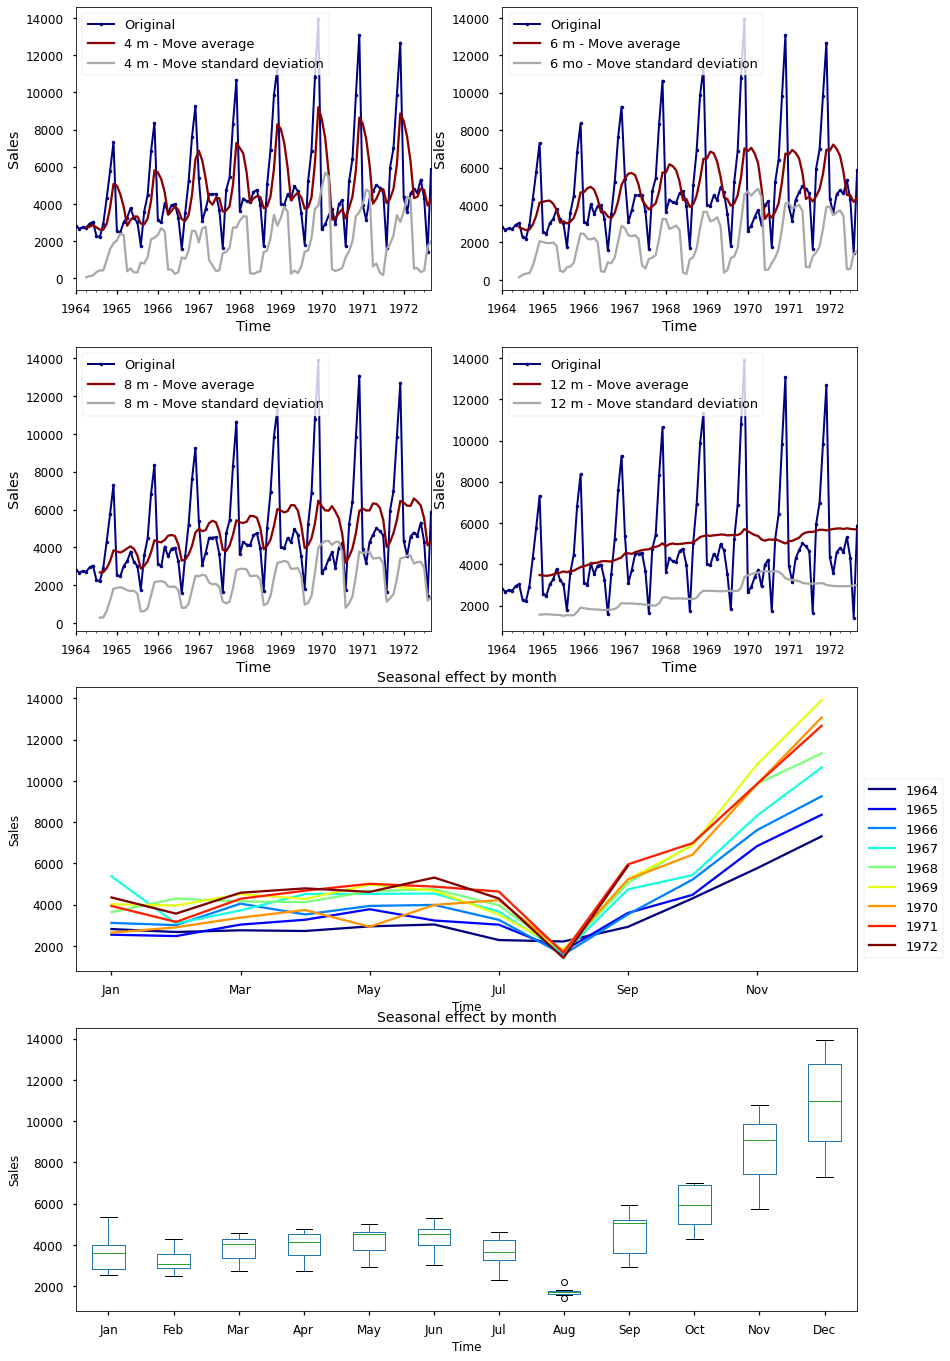

In [7]:
#Apply trend and seasonal analysis to chamoagne serie 
tst.ts_trendseason(serie_df, ylab1="Sales")

- 1. Is there a significant trend in the increase in sales of champagne?

By the trend graph with 4, 6, 8 and 12 move avarege or satandard deviation we can see a positive trend in the champagne serie. There is a positive increase in champagne sold. We can answare better this question by time serie decomposition in next analysis. 

- 2. Is there a significant seasonal effect on champagne sales?

Yes, we can find a seasonal effect in time serie. By the month seasonal effect graph it is possible to affirm that there is a strong seasonal effect between the months.

- A. In which month is the most champagne sold?

December it is the month with most champagne sold. Possibly because December is the month with the festivities that end the year.

- B. Which month represents the lowest sale?

August is the month wit lowest sales. What is the reason? Why august? Well, we can to afirm that August is the same with fewer holidays and festivities. This may just be the beginning of the answer, we should check if there is a possibility that sellers will not make the product available thinking about the end of the year that is coming. We can also think that production decreases. A number of other factors, more information would be needed to extract more knowledge about it.

- C. Is it possible to quantify a growth rate in sales?

To find the growth rate of our time series, let's apply the expression para Variação percentual da série, $\% \Delta \; Sales_{t_0t} = [(Sales_t / Sales_{t_0}) - 1] \cdot 100$. Let's calculate the percentage growth and express it graphically along with the original series.


In [8]:
# Calculeted of percently growth or 'rentability in business series' 
serie_df["growth_rate"] = ((serie_df.Sales/serie_df.Sales.shift()) - 1) * 100
serie_df.head()

,Sales,month_n,Month,Year,growth_rate
Month,,,,,
1964-01-01,2815,1,Jan,1964,NaN
1964-02-01,2672,2,Feb,1964,-5.079929
1964-03-01,2755,3,Mar,1964,3.106287
1964-04-01,2721,4,Apr,1964,-1.234120
1964-05-01,2946,5,May,1964,8.269019


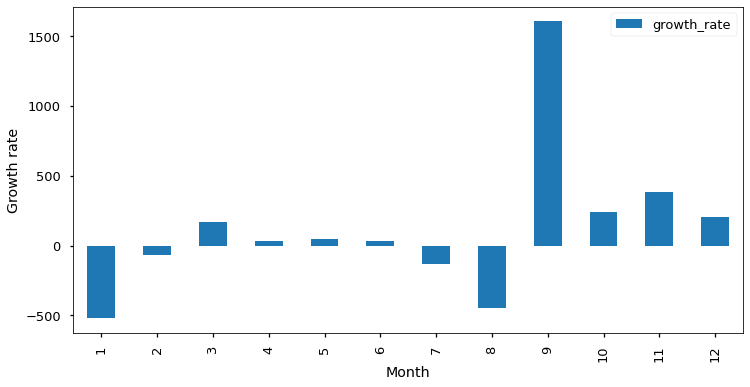

In [9]:
#growpt rate by month
serie_df.groupby("month_n").agg({"growth_rate":"sum"}).plot(kind="bar", figsize=(12,6), 
                                                            xlabel="Month", ylabel="Growth rate");

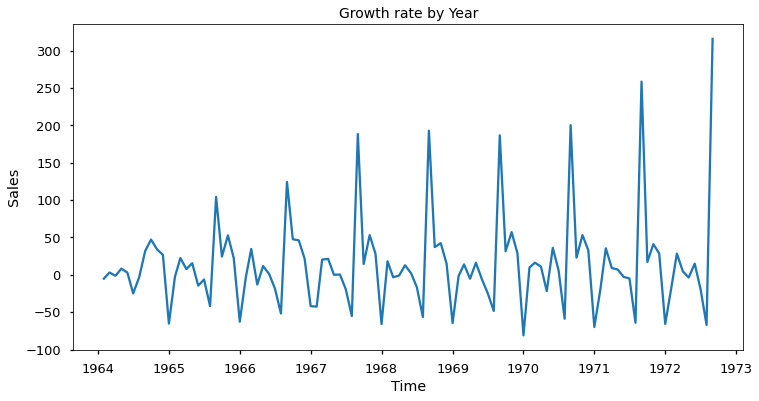

In [10]:
# Graph original time serie and growth rate
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(serie_df.growth_rate)
ax.set_ylabel("Sales")
ax.set_xlabel("Time")
ax.set_title("Growth rate by Year", fontsize = 14);

### Time serie decomposition

Now we move on to a more detailed analysis of our series: graphical analysis of autocorrelation, and partial autocorrelation, qq plot, histogram and ADF-augmented Dickey Fuller test.

/home/wesley/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


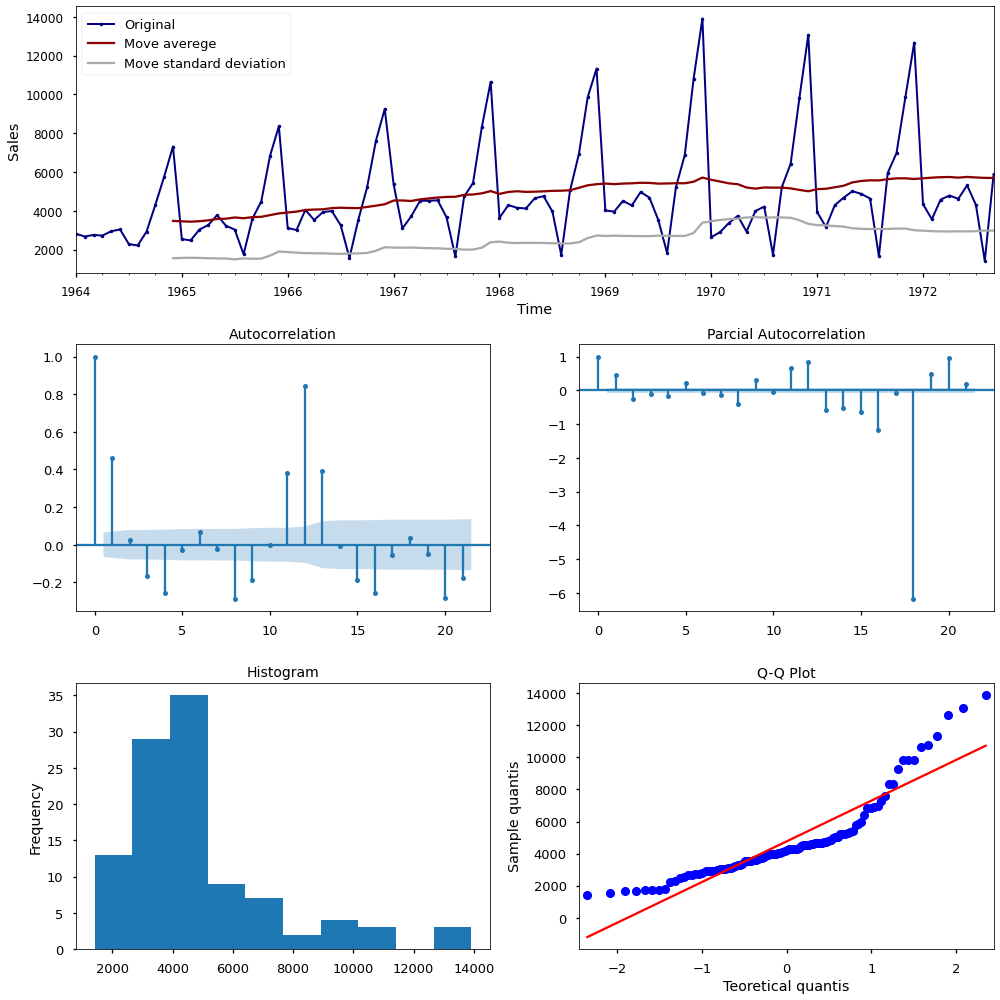



Results of Augmented Dickey-Fuller test:

If p-value < 0.05: Reject null hipoteses, the time serie is stationarity by 5% of significance.
test statistic          -1.833593
p-value                  0.363916
# of lags               11.000000
# of observations       93.000000
Critical Value (1%)     -3.502705
Critical Value (5%)     -2.893158
Critical Value (10%)    -2.583637
dtype: float64


In [11]:
#decomposition and stationarity 
tst.ts_feature(serie, ylab="Sales")

With these analyzes we can conclude that in addition to the positive trend in sales of champagne, the series is not normally distributed, according to the histogram graph and qq plot, in this way the inference on mainly classical models of time series (arima, sarima), can be committed. With the augmented dickey fuller test we understand that the series is non-stationary, so we must add autoregressive components to the model.

## Dataset treatment

Now, we go to split the dataset into train and validation set. 

- dataset.csv: Datas of 1964 to setember of 1971.

- validation.csv: Data of October 1971 until October of 1972 (1 year of sales).


In [3]:
# number of rows minus 12
split_point = len(serie) - 12

# dataset have datas utnil the split_point in rows
dataset = serie[0:split_point]

# the validation csv has data before split_point
validation = serie[split_point:]

# save into disc
dataset.to_csv('../Projects/datasets/dataset.csv')

# save into disc
validation.to_csv('../Projects/datasets/validation.csv')

## Specific a Baseline (Benchmark)

- A baseline is a simple value we have to start our project.
- It serves as a reference to know how our model is performing.
- Example: Forecast value is the previous value, in our case, the previous month's value.

In [13]:
# Read the dataset in disc
series = pd.read_csv('../Projects/datasets/champagne_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# set the data into X 
X = series.values

# define the length train set (50%)
train_size = int(len(X) * 0.50)

# train and test: this pratic is not stronger recomended, because we have the validation test defined
train = X[0:train_size]
test = X[train_size:]

# train data historic
history = [x for x in train]

# predictions list
predictions = list()

# applied naive model: baseline
for i in range(len(test)):
  
  # predict_value receives the last value of the training set
  predict_value = history[-1]
  
  # the first prediction is the last value of train set
  predictions.append(predict_value)
  
  # original_value receives the current value of the test.
  original_value = test[i]
  
  # add the original_value to historic list
  history.append(original_value)
  
  # print the predict value and original value
  print('Predict Value = %.3f, Value Spected = %3.f' % (predict_value, original_value))

Predict Value = 4121.000, Value Spected = 4647
Predict Value = 4647.000, Value Spected = 4753
Predict Value = 4753.000, Value Spected = 3965
Predict Value = 3965.000, Value Spected = 1723
Predict Value = 1723.000, Value Spected = 5048
Predict Value = 5048.000, Value Spected = 6922
Predict Value = 6922.000, Value Spected = 9858
Predict Value = 9858.000, Value Spected = 11331
Predict Value = 11331.000, Value Spected = 4016
Predict Value = 4016.000, Value Spected = 3957
Predict Value = 3957.000, Value Spected = 4510
Predict Value = 4510.000, Value Spected = 4276
Predict Value = 4276.000, Value Spected = 4968
Predict Value = 4968.000, Value Spected = 4677
Predict Value = 4677.000, Value Spected = 3523
Predict Value = 3523.000, Value Spected = 1821
Predict Value = 1821.000, Value Spected = 5222
Predict Value = 5222.000, Value Spected = 6872
Predict Value = 6872.000, Value Spected = 10803
Predict Value = 10803.000, Value Spected = 13916
Predict Value = 13916.000, Value Spected = 2639
Predict

To assess the goodness of fit of our model, we will use the statistical test of the square root of the mean error, this test returns a value on the same scale as the data, this facilitates the understanding of the size of the error made by the model. Our baseline has an error of 3167.362 of sales number. 

In [13]:
# naive model (baseline) validation
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

### Arima model with Walk-Forward

- AR: autoregressive component (p);
- I: integrate component (d);
- MA: Move average componnet (q);

The ARIMA function receive dataset and (p,d,q) parammeters. 

In [15]:
#libs
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

In [16]:
# How our data is not statationarity we create a functon that calculate the difference bethwen values
# differentiation function
def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# inverse differentiation function
def inverse_difference(history, predict, interval=1):
  return predict + history[-interval]

In [17]:
#fit arima model with metodology walk-forward 

# set the data into X 
X = dataset.values

# define the length train set (50%)
train_size = int(len(X) * 0.50)

# train and test: this pratic is not stronger recomended, because we have the validation test defined
train = X[0:train_size]
test = X[train_size:]

# WARNING: walk-forward with step = 1, to big data the step need increase.

# train data historic
history = [x for x in train]

# predictions list
predictions = list()

# applied Walk-Forward with arima model
for t in range(len(test)):
  
  # difference data
  meses_no_ano = 12
  diff = difference(dataset=history, interval=meses_no_ano)
  
  # instance a arima model with history data
  model = ARIMA(diff, order=(1,1,1))
  
  # fit model arima
  model_fit = model.fit()
  
  # the object predict_value receive the fit value
  predict_value = model_fit.forecast()[0]

  # inverse difference of the fit model
  predict_value = inverse_difference(history, predict_value, meses_no_ano)
   
  # the first prediction is the fit value by the model
  predictions.append(predict_value)
  
  # original_value receives the current value of the test.
  original_value = test[t]
  
  #  add the original_value to historic list
  history.append(original_value)

  # print the predict value and original value
  print('Predict value=%.3f, Original value=%3.f' % (predict_value, original_value))

Predict value=8076.987, Original value=8314
Predict value=9747.154, Original value=10651
Predict value=5994.362, Original value=3633
Predict value=3820.287, Original value=4292
Predict value=4041.968, Original value=4154
Predict value=4990.405, Original value=4121
Predict value=5129.641, Original value=4647
Predict value=5031.196, Original value=4753
Predict value=4133.285, Original value=3965
Predict value=2095.321, Original value=1723
Predict value=5216.271, Original value=5048
Predict value=5866.317, Original value=6922
Predict value=8591.061, Original value=9858
Predict value=11028.649, Original value=11331
Predict value=4090.352, Original value=4016
Predict value=4767.109, Original value=3957
Predict value=4656.326, Original value=4510
Predict value=4577.708, Original value=4276
Predict value=5108.656, Original value=4968
Predict value=5202.831, Original value=4677
Predict value=4423.982, Original value=3523
Predict value=2162.388, Original value=1821
Predict value=5463.233, Origi

In [18]:
# Model fit quality in train dataset
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 961.549


In [19]:
# the object predict_value receive the fit value
predict_values = model_fit.get_forecast(steps=12)

# inverse difference of the fit model
predict_values = inverse_difference(history, predict_values.predicted_mean, meses_no_ano)
   
# Model fit quality in train dataset
rmse = sqrt(mean_squared_error(validation.values, predict_values))
print('Validation RMSE: %.3f' % rmse)

Validation RMSE: 3039.446


### Model diagnostic

Every machine learning model (here we include models for: regression, classification, clustering, time series, deep learning, etc.) In this way, we will investigate whether the fitted model meets the assumptions required by the Box Jenkins method.

In [20]:
# Tests to evaluate the assumptions of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -640.491
Date:                Wed, 09 Mar 2022   AIC                           1286.981
Time:                        10:05:05   BIC                           1294.090
Sample:                             0   HQIC                          1289.829
                                 - 80                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2283      0.087      2.612      0.009       0.057       0.400
ma.L1         -0.9984      0.440     -2.269      0.023      -1.861      -0.136
sigma2      6.174e+05   2.69e+05      2.298      0.022    9.08e+04    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 8.50
Prob(Q):                              0.85   Prob(JB):                         0.01
Heteroskedasticity (H):               3.08   Skew:                            -0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

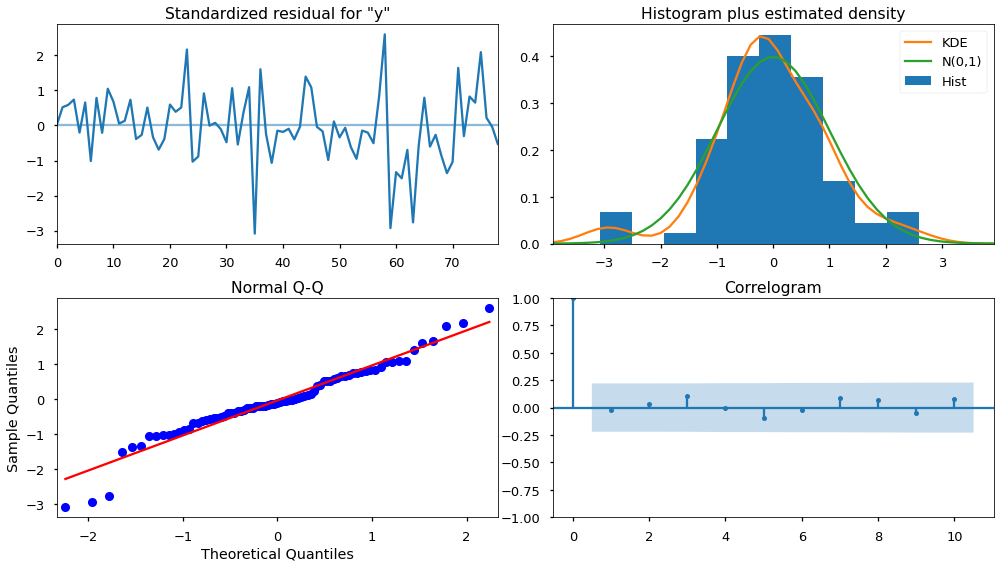

In [21]:
#graphical analysis of residuals
model_fit.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

### Applied a Seasonal model (SARIMA)

SARIMA(p, d, q).(P,D,Q)m

    SARIMA is used for non-stationary series, that is, the data do not fluctuate around the mean. This model can identify trend and seasonality.

     Why is seasonality important?

Seasonality is especially important when we know that sales increase or decrease at certain events (holidays, winter, summer, etc). We may want to model these phenomena.

To adjust these models, we will use the grid search technique, which consists of defining a range of values for each parameter and then combining these parameters, training a model for each combination and selecting the parameters that resulted in the best model.

In [25]:
import statsmodels.api as sm
from pmdarima import auto_arima

In [26]:
# Make a grid search to improve the fit quality of model 
fit_arima = auto_arima(dataset, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=12, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1301.280, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1334.493, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1318.296, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1306.012, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1302.360, Time=0.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1300.749, Time=0.40 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1304.592, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1300.463, Time=1.61 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1304.881, Time=0.80 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1318.501, Time=0.62 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1302.444, Time=1.71 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=1302.436, Time=1.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1326.335, Time=0.43 sec
 ARIMA(0,1,2)(2,1,0)[12]

In [27]:
# Fit the model with parammeters of the best model
model = sm.tsa.statespace.SARIMAX(dataset.values, order=(1,1,1), seasonal_order=(2,1,0, meses_no_ano))
sarimax_result = model.fit(disp = False)

In [28]:
#Parameters and hipoteses tests
sarimax_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -645.231
Date:                             Wed, 09 Mar 2022   AIC                           1300.463
Time:                                     10:07:05   BIC                           1312.373
Sample:                                          0   HQIC                          1305.238
                                              - 93                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2997      0.092      3.255      0.001       0.119       0.480
ma.L1         -0.9497      0.046    -20.569      0.000      -1.040      -0.859
ar.S.L12      -0.2236      0.087     -2.574      0.010      -0.394      -0.053
ar.S.L24       0.1744      0.087      2.016      0.044       0.005       0.344
sigma2      5.346e+05   7.14e+04      7.487      0.000    3.95e+05    6.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 3.63
Prob(Q):                              0.58   Prob(JB):                         0.16
Heteroskedasticity (H):               1.87   Skew:                            -0.11
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

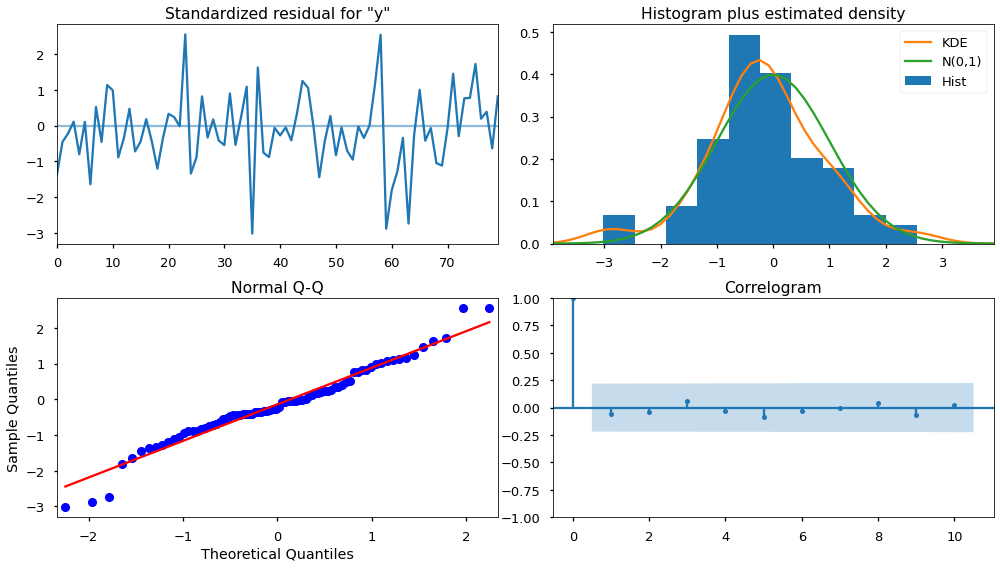

In [29]:
#graphical analysis of residuals
sarimax_result.plot_diagnostics(figsize=(14, 8))
plt.tight_layout()
plt.show()

In [30]:
# the object predict_value receive the fit value
predict_sarima = sarimax_result.get_forecast(steps=12)

# Root mean square error to Validation dataset
rmse = sqrt(mean_squared_error(validation.values, predict_sarima.predicted_mean))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 571.858


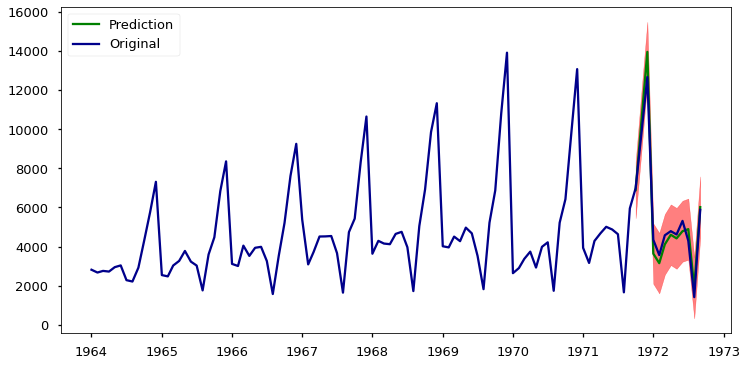

In [31]:
# Confidence Interval
confidence_interval = predict_sarima.conf_int()
upp_ci = [x[1] for x in confidence_interval]
lower_ci = [x[0] for x in confidence_interval]

#Concat original serie to plot in the grap
original_serie = pd.concat([dataset, validation])

# Time Serie Original and Predict
plt.figure(figsize=(12,6))
plt.plot(validation.index, predict_sarima.predicted_mean, color='green',label='Prediction')
plt.fill_between(validation.index, lower_ci, upp_ci, color='red', alpha=0.5)
plt.plot(original_serie.index, original_serie.values, label='Original', color='darkblue')
plt.legend()
plt.show()

### Facebook Prophet

- Library created by Facebook with the aim of being used on the social network.
- Motivation: Facilitate the creation of models without necessarily having experts for it.
- Focused on modeling seasonality, holiday effects and handling missing values.

In [37]:
#To install Facebook prophet running the below command

#!pip install pystan==2.19.1.1
#!pip install fbprophet 

In [6]:
# import the prophet librarie
from fbprophet import Prophet

In [7]:
# ds: temporal features 
# y: train values

data_train = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

# instaceing the prophet object
model = Prophet()

# fit the model
model.fit(data_train)

# future data generation
ph_future = model.make_future_dataframe(periods = 12, freq='M')

# forecasting values
ph_forecast = model.predict(ph_future)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
# validation dataset
validation_df = pd.DataFrame({'ds': validation.index})

# forecast prophet in validation dataset
ph_forecast_val = model.predict(validation_df)

rmse = sqrt(mean_squared_error(validation.values, ph_forecast_val.yhat))
print('Validation RMSE: %.3f' % rmse)

Validation RMSE: 754.079


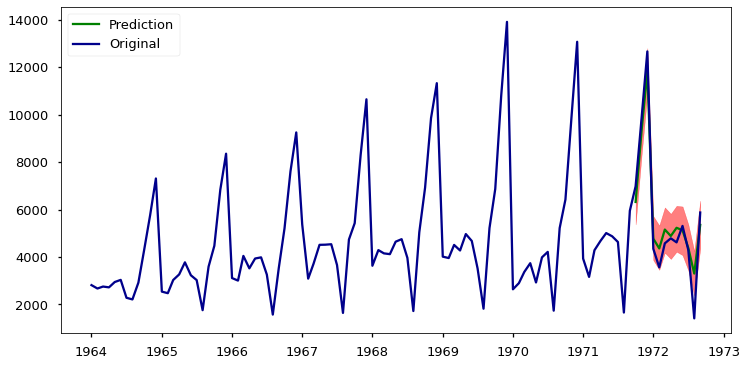

In [21]:
#Concat original serie to plot in the grap
original_serie = pd.concat([dataset, validation])

# Time Serie Original and Predict
plt.figure(figsize=(12,6))
plt.plot(ph_forecast_val.ds, ph_forecast_val.yhat, color='green',label='Prediction')
plt.fill_between(ph_forecast_val.ds, ph_forecast_val.yhat_lower, ph_forecast_val.yhat_upper, color='red', alpha=0.5)
plt.plot(original_serie.index, original_serie.values, label='Original', color='darkblue')
plt.legend()
plt.show()

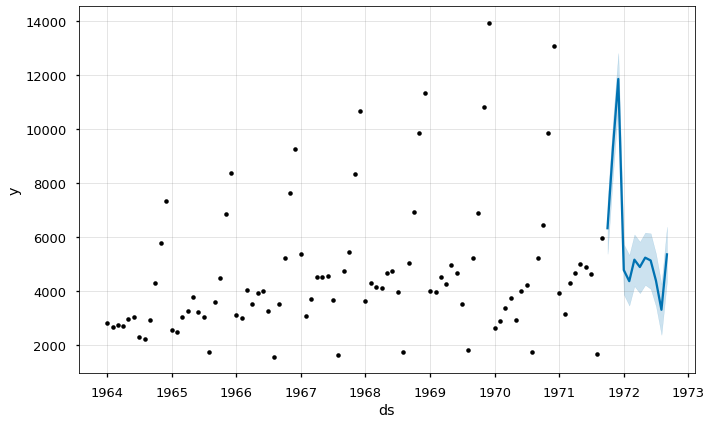

In [22]:
# Python
fig = model.plot(ph_forecast_val)

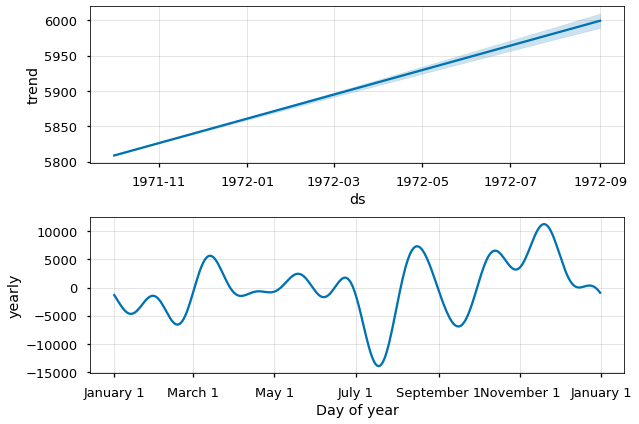

In [24]:
model.plot_components(ph_forecast_val);

#### Prophet tunning

- `seasonality_mode`: This parameter indicates how your seasonality components should be integrated into forecasts. The default value is `additive`, with the `multiplicative` parameter being the other option. You should use the additive when your seasonality trend is "constant" throughout the period. For example, when you want your annual trend growth impact to be the same as in 2010 and 2018. This is applicable in data where the trend change appears to remain constant, for example the number of people living in a city little. This is because we don't expect growth to suddenly increase by the millions, because there is no infrastructure for that. On the other hand, when we want to predict the amount of people living in a growing city, the annual number of trends can be much more important in recent years as the infrastructure exists. The population growth rate may be much faster than it would have been in the early years. In a case like this, you'll use multiplicative to increase the importance of seasonality over time.

- `seasonality_prior_scale`. This parameter will again allow your seasonalities to be more flexible. You can set the `annual_seasonality`, `Weekly_seasonality` and `daily_seasonality` parameters separately or add your own seasonality setting.

In [25]:
# Change seasonality
model = Prophet(seasonality_mode='multiplicative')
model.fit(data_train)
validation_df = pd.DataFrame({'ds': validation.index})
ph_forecast_tun = model.predict(validation_df)

rmse = sqrt(mean_squared_error(validation.values, ph_forecast_tun.yhat))
print('Test RMSE: %.3f' % rmse)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test RMSE: 499.768


In [ ]:
from xgboost import XGBRegressor